# Final Project Data Analytics and IoT
## GeoLife Trajectories 

In [33]:
import numpy as np
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0
from tensorflow import keras
import matplotlib.pyplot as plt
import scikitplot

from prepare_data import prepare_data
import lstm_time_series
import transformer_classifier
from plot_model_history import plot_model_history
from generate_tableau_csv import generate_tableau_csv

## Data Exploration
This code reads GPS data from a randomly chosen .plt file in a specified directory, converts the latitude and longitude coordinates into Point objects, and creates a geopandas DataFrame to represent the data. The resulting DataFrame is then plotted on a map using the plot() method of the geopandas DataFrame.

Text(0.5, 1.0, 'Geolife Trajectory')

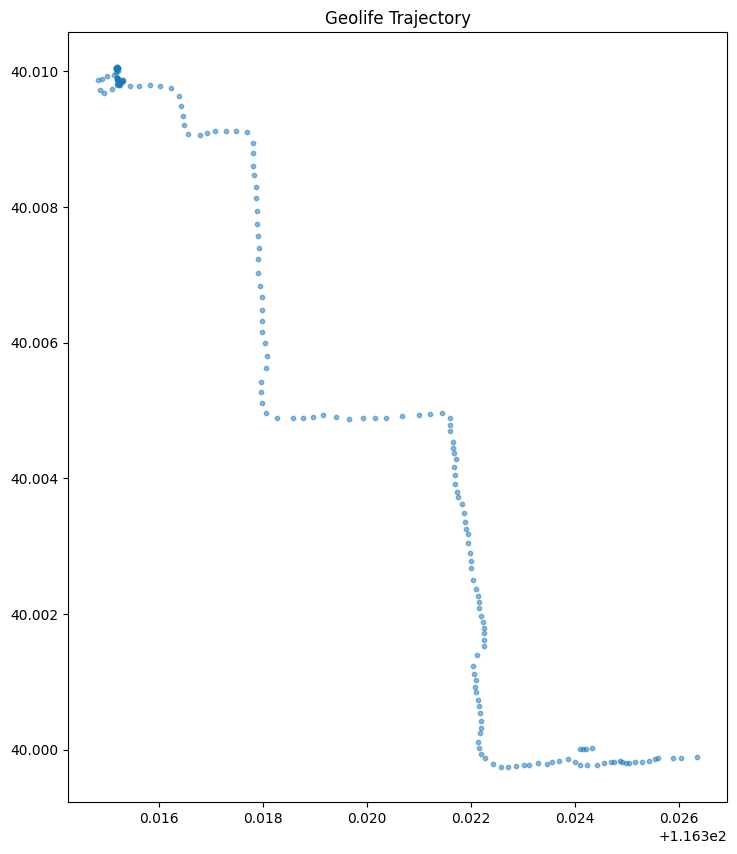

In [19]:
import os
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Set the directory where the PLT files are located
dir_path = 'C:/Users/Ali Kian/GeoLife-Trajectories-main/GeoLife-Trajectories-main/000/Trajectory'

# Get a list of all the PLT files in the directory
file_list = [f for f in os.listdir(dir_path) if f.endswith('.plt')]

# Choose a random PLT file from the list
plt_file = random.choice(file_list)

# Read the data from the PLT file
with open(os.path.join(dir_path, plt_file), 'r') as f:
    data = f.readlines()[6:]
data = [line.strip().split(',')[:6] for line in data]

# Create a pandas DataFrame and convert the latitude and longitude columns into Point objects
df = pd.DataFrame(data, columns=['lat', 'lon', 'alt', 'num_days', 'date', 'time'])
geometry = [Point(xy) for xy in zip(df.lon.astype(float), df.lat.astype(float))]

# Create a geopandas DataFrame using the pandas DataFrame and the Point objects
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Plot the data
ax = gdf.plot(figsize=(10, 10), alpha=0.5, markersize=10)
ax.set_title('Geolife Trajectory')

## Data Preparation
Create a pandas dataframe with every data point that has a label. 
This helper function code reads multiple GPS trajectory files from 181 folders, converts the altitude column from feet to meters, merges all dataframes into a single dataframe, and adds a label column to the dataframe based on the transportation mode mentioned in the corresponding text file (if available). The label addition function 'add_labels()' creates a list of dataframes, loops over each folder, checks if there is a text file present, and if so, it loads the text file into a dataframe, converts the start and end time columns into datetime format, and adds the label to the main dataframe by comparing it with the time column of the dataframe using the 'is_between()' function. Finally, the labeled dataframe is saved as a pickle file named 'df_labels.pkl'. (This process will take a long time due huge amount of data being processesd)

In [2]:
add_labels()

## Data Cleaning
Because of the way the data was collected, there are some discontinuous entries. Randomly large time gaps exist, as well as adjacent points that have different labels.

Also, we need to prepare the data for the model training.

In this step, we divide the data into sequences of 100 points. Each sequence will have smaller time-steps between points, and will have only one label.

We also converted the latitude and longitude into x, y, and z coordinates for easier deep learning training, and calculated the distance between subsequent point, for velocity information.

We save the resulting arrays for easier testing.

Uncomment and run to create.

In [12]:
from clean_data import split_dataframe
from clean_data import create_sequences 
sequence_data, label_array =create_sequences()
with open('seq_labels.npz', 'wb') as f:
    np.savez(f, sequence_data, label_array)

Loading dataset...
Add sequence information...
Split sequences that are separated in time...
Add distance information...
Creating dataset...


C:\Users\Ali Kian\GeoLife-Trajectories-main_v1\GeoLife-Trajectories-main\clean_data.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequence.loc[:, 'timedelta'] = (sequence['Datetime'] - sequence['Datetime'].shift()) \


## Prepare data for training
Split data into train and test sets, scale using min-max scalar

In [20]:
x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm, _, _ = prepare_data('lstm')
input_shape_lstm = x_train_lstm.shape[1:]
output_shape_lstm = y_train_lstm.shape[1:][0]

x_train_transformer, \
    y_train_transformer, \
    x_test_transformer, \
    y_test_transformer, _, num_classes = prepare_data('transformer')
input_shape_transformer = x_train_transformer.shape[1:]

## Build the time series Model use LSTM
Model Building: Create a multi-layer LSTM network using the extracted features and normalized values as input. The output layer should have as many nodes as the number of features you want to predict (in this case, 3).

Training: Train the model using a suitable optimizer and loss function on the preprocessed data. Monitor the accuracy of the model on a validation set during training.

Testing: Finally, test the model on unseen data to evaluate its performance in predicting the GPS trajectory.

In [21]:
lstm_model = lstm_time_series.build_model(input_shape_lstm, output_shape_lstm)

Uncomment below to train LSTM and save weights

In [22]:
lstm_time_series.run_model()

Epoch 1/250
369/372 [============================>.] - ETA: 0s - loss: 0.0466
Epoch 1: val_loss improved from inf to 0.00680, saving model to lstm_model.h5
372/372 [==============================] - 9s 9ms/step - loss: 0.0463 - val_loss: 0.0068 - lr: 1.0000e-04
Epoch 2/250
368/372 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 2: val_loss improved from 0.00680 to 0.00580, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 0.0063 - val_loss: 0.0058 - lr: 1.0000e-04
Epoch 3/250
369/372 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 3: val_loss improved from 0.00580 to 0.00355, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 0.0045 - val_loss: 0.0036 - lr: 1.0000e-04
Epoch 4/250
367/372 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 4: val_loss improved from 0.00355 to 0.00237, saving model to lstm_model.h5
372/372 [==============================] - 3s 

Epoch 62/250
371/372 [============================>.] - ETA: 0s - loss: 1.6683e-05
Epoch 62: val_loss did not improve from 0.00002
372/372 [==============================] - 3s 9ms/step - loss: 1.6682e-05 - val_loss: 1.7449e-05 - lr: 1.0000e-06
Epoch 63/250
372/372 [==============================] - ETA: 0s - loss: 1.6652e-05
Epoch 63: val_loss improved from 0.00002 to 0.00002, saving model to lstm_model.h5
372/372 [==============================] - 4s 10ms/step - loss: 1.6652e-05 - val_loss: 1.7268e-05 - lr: 1.0000e-06
Epoch 64/250
370/372 [============================>.] - ETA: 0s - loss: 1.6570e-05
Epoch 64: val_loss improved from 0.00002 to 0.00002, saving model to lstm_model.h5
372/372 [==============================] - 4s 10ms/step - loss: 1.6597e-05 - val_loss: 1.7232e-05 - lr: 1.0000e-06
Epoch 65/250
371/372 [============================>.] - ETA: 0s - loss: 1.6561e-05
Epoch 65: val_loss improved from 0.00002 to 0.00002, saving model to lstm_model.h5
372/372 [==================

Epoch 93/250
372/372 [==============================] - ETA: 0s - loss: 1.5492e-05
Epoch 93: val_loss improved from 0.00002 to 0.00002, saving model to lstm_model.h5
372/372 [==============================] - 9s 24ms/step - loss: 1.5492e-05 - val_loss: 1.6073e-05 - lr: 1.0000e-06
Epoch 94/250
367/372 [============================>.] - ETA: 0s - loss: 1.5471e-05
Epoch 94: val_loss did not improve from 0.00002
372/372 [==============================] - 26s 71ms/step - loss: 1.5418e-05 - val_loss: 1.6260e-05 - lr: 1.0000e-06
Epoch 95/250
372/372 [==============================] - ETA: 0s - loss: 1.5404e-05
Epoch 95: val_loss improved from 0.00002 to 0.00002, saving model to lstm_model.h5
372/372 [==============================] - 68s 183ms/step - loss: 1.5404e-05 - val_loss: 1.5975e-05 - lr: 1.0000e-06
Epoch 96/250
369/372 [============================>.] - ETA: 0s - loss: 1.5300e-05
Epoch 96: val_loss did not improve from 0.00002
372/372 [==============================] - 4s 11ms/step - 

Epoch 124/250
370/372 [============================>.] - ETA: 0s - loss: 1.4411e-05
Epoch 124: val_loss improved from 0.00002 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 8ms/step - loss: 1.4406e-05 - val_loss: 1.4980e-05 - lr: 1.0000e-06
Epoch 125/250
365/372 [============================>.] - ETA: 0s - loss: 1.4422e-05
Epoch 125: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 8ms/step - loss: 1.4367e-05 - val_loss: 1.4944e-05 - lr: 1.0000e-06
Epoch 126/250
370/372 [============================>.] - ETA: 0s - loss: 1.4338e-05
Epoch 126: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 8ms/step - loss: 1.4310e-05 - val_loss: 1.4810e-05 - lr: 1.0000e-06
Epoch 127/250
368/372 [============================>.] - ETA: 0s - loss: 1.4261e-05
Epoch 127: val_loss did not improve from 0.00001
372/372 [============

372/372 [==============================] - 3s 8ms/step - loss: 1.3472e-05 - val_loss: 1.3937e-05 - lr: 1.0000e-06
Epoch 155/250
370/372 [============================>.] - ETA: 0s - loss: 1.3487e-05
Epoch 155: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 8ms/step - loss: 1.3482e-05 - val_loss: 1.3898e-05 - lr: 1.0000e-06
Epoch 156/250
370/372 [============================>.] - ETA: 0s - loss: 1.3424e-05
Epoch 156: val_loss did not improve from 0.00001
372/372 [==============================] - 3s 7ms/step - loss: 1.3415e-05 - val_loss: 1.3929e-05 - lr: 1.0000e-06
Epoch 157/250
369/372 [============================>.] - ETA: 0s - loss: 1.3348e-05
Epoch 157: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 1.3384e-05 - val_loss: 1.3887e-05 - lr: 1.0000e-06
Epoch 158/250
368/372 [============================>.] - ETA: 0s - loss: 1.

365/372 [============================>.] - ETA: 0s - loss: 1.2668e-05
Epoch 185: val_loss did not improve from 0.00001
372/372 [==============================] - 3s 7ms/step - loss: 1.2682e-05 - val_loss: 1.3378e-05 - lr: 1.0000e-06
Epoch 186/250
367/372 [============================>.] - ETA: 0s - loss: 1.2646e-05
Epoch 186: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 1.2649e-05 - val_loss: 1.3164e-05 - lr: 1.0000e-06
Epoch 187/250
365/372 [============================>.] - ETA: 0s - loss: 1.2586e-05
Epoch 187: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 1.2628e-05 - val_loss: 1.3019e-05 - lr: 1.0000e-06
Epoch 188/250
372/372 [==============================] - ETA: 0s - loss: 1.2598e-05
Epoch 188: val_loss did not improve from 0.00001
372/372 [==============================] - 3s 7ms/step - loss: 1.2598e

372/372 [==============================] - 3s 7ms/step - loss: 1.2005e-05 - val_loss: 1.2436e-05 - lr: 1.0000e-06
Epoch 216/250
365/372 [============================>.] - ETA: 0s - loss: 1.1983e-05
Epoch 216: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 1.1964e-05 - val_loss: 1.2367e-05 - lr: 1.0000e-06
Epoch 217/250
365/372 [============================>.] - ETA: 0s - loss: 1.1928e-05
Epoch 217: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 1.1916e-05 - val_loss: 1.2365e-05 - lr: 1.0000e-06
Epoch 218/250
365/372 [============================>.] - ETA: 0s - loss: 1.1897e-05
Epoch 218: val_loss improved from 0.00001 to 0.00001, saving model to lstm_model.h5
372/372 [==============================] - 3s 7ms/step - loss: 1.1907e-05 - val_loss: 1.2275e-05 - lr: 1.0000e-06
Epoch 219/250
365/372 [=================

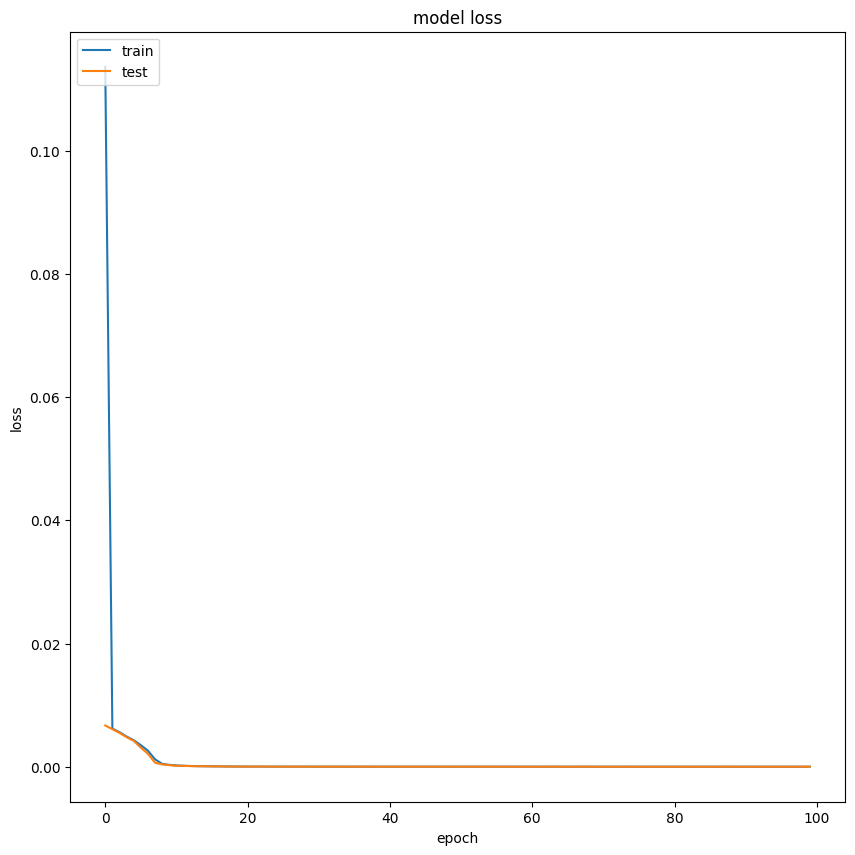

In [23]:
plot_model_history('lstm_history.txt')

In [24]:
# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4))

# Load the saved model
lstm_model.load_weights('lstm_model.h5')

lstm_model.evaluate(x_test_lstm, y_test_lstm, verbose=1)

233/233 [==============================] - 2s 4ms/step - loss: 2.5118e-05


2.5118139092228375e-05

4/4 [==============================] - 1s 5ms/step


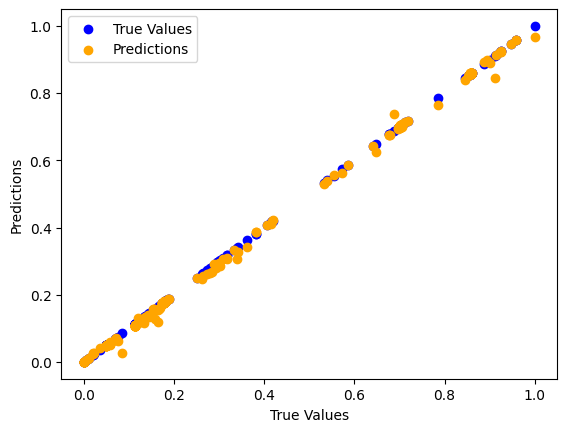

In [25]:
# Get the predicted values for the first 100 points in the test dataset
n = 100
x_sample = x_test_lstm[:n]
y_true = y_test_lstm[:n]
y_pred = lstm_model.predict(x_sample)

# Create a scatter plot comparing the predicted values to the true values
plt.scatter(y_true, y_true, c='blue', label='True Values')
plt.scatter(y_true, y_pred, c='orange', label='Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

## Transformer Model
The code defines and trains a transformer-based model for a classification task on a given dataset. The dataset is prepared using a function called prepare_data, and the model is defined using the transformer_encoder and build_model functions. The transformer_encoder function implements a multi-head attention mechanism and dense layers for normalization, dropout, and residual connection. The build_model function applies multiple transformer blocks to the input data using the transformer_encoder function, followed by convolutional layers, pooling, and dense layers to generate the output. The model is compiled with the sparse_categorical_crossentropy loss function and the Adam optimizer with a reduced learning rate on plateau. The model is trained for 100 epochs with a batch size of 64 and callbacks for early stopping, checkpointing, and reducing learning rate on plateau. The trained model is evaluated on a test dataset using the evaluate function.

In [26]:
transformer_model = transformer_classifier.build_model(input_shape_transformer,
                                                       num_heads=4,
                                                        num_transformer_blocks=4,
                                                        dropout=0.25)

In [27]:
transformer_classifier.run_model()

Epoch 1/100
371/372 [============================>.] - ETA: 0s - loss: 1.3693 - sparse_categorical_accuracy: 0.3177
Epoch 1: val_loss improved from inf to 1.33295, saving model to transformer_model.h5
372/372 [==============================] - 18s 27ms/step - loss: 1.3692 - sparse_categorical_accuracy: 0.3176 - val_loss: 1.3330 - val_sparse_categorical_accuracy: 0.3838 - lr: 1.0000e-04
Epoch 2/100
372/372 [==============================] - ETA: 0s - loss: 1.3322 - sparse_categorical_accuracy: 0.3871
Epoch 2: val_loss improved from 1.33295 to 1.31819, saving model to transformer_model.h5
372/372 [==============================] - 8s 22ms/step - loss: 1.3322 - sparse_categorical_accuracy: 0.3871 - val_loss: 1.3182 - val_sparse_categorical_accuracy: 0.3838 - lr: 1.0000e-04
Epoch 3/100
370/372 [============================>.] - ETA: 0s - loss: 1.3183 - sparse_categorical_accuracy: 0.3876
Epoch 3: val_loss improved from 1.31819 to 1.30544, saving model to transformer_model.h5
372/372 [=====

372/372 [==============================] - 10s 26ms/step - loss: 0.8628 - sparse_categorical_accuracy: 0.6555 - val_loss: 0.8116 - val_sparse_categorical_accuracy: 0.6586 - lr: 1.0000e-04
Epoch 44/100
372/372 [==============================] - ETA: 0s - loss: 0.8564 - sparse_categorical_accuracy: 0.6611
Epoch 44: val_loss improved from 0.81159 to 0.80168, saving model to transformer_model.h5
372/372 [==============================] - 10s 26ms/step - loss: 0.8564 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.8017 - val_sparse_categorical_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 45/100
372/372 [==============================] - ETA: 0s - loss: 0.8478 - sparse_categorical_accuracy: 0.6696
Epoch 45: val_loss improved from 0.80168 to 0.79264, saving model to transformer_model.h5
372/372 [==============================] - 10s 26ms/step - loss: 0.8478 - sparse_categorical_accuracy: 0.6696 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.7001 - lr: 1.0000e-04
Epoch 46/100
370/372 [

Epoch 65/100
372/372 [==============================] - ETA: 0s - loss: 0.7804 - sparse_categorical_accuracy: 0.7142
Epoch 65: val_loss did not improve from 0.72417
372/372 [==============================] - 9s 25ms/step - loss: 0.7804 - sparse_categorical_accuracy: 0.7142 - val_loss: 0.7314 - val_sparse_categorical_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 66/100
371/372 [============================>.] - ETA: 0s - loss: 0.7835 - sparse_categorical_accuracy: 0.7122
Epoch 66: val_loss improved from 0.72417 to 0.71710, saving model to transformer_model.h5
372/372 [==============================] - 10s 26ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.7171 - val_sparse_categorical_accuracy: 0.7373 - lr: 1.0000e-04
Epoch 67/100
372/372 [==============================] - ETA: 0s - loss: 0.7801 - sparse_categorical_accuracy: 0.7158
Epoch 67: val_loss improved from 0.71710 to 0.71187, saving model to transformer_model.h5
372/372 [==============================] - 9s 

Epoch 87/100
370/372 [============================>.] - ETA: 0s - loss: 0.7473 - sparse_categorical_accuracy: 0.7286
Epoch 87: val_loss did not improve from 0.67327
372/372 [==============================] - 9s 23ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7289 - val_loss: 0.6812 - val_sparse_categorical_accuracy: 0.7522 - lr: 1.0000e-04
Epoch 88/100
370/372 [============================>.] - ETA: 0s - loss: 0.7470 - sparse_categorical_accuracy: 0.7277
Epoch 88: val_loss did not improve from 0.67327
372/372 [==============================] - 9s 23ms/step - loss: 0.7472 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.6831 - val_sparse_categorical_accuracy: 0.7541 - lr: 1.0000e-04
Epoch 89/100
372/372 [==============================] - ETA: 0s - loss: 0.7399 - sparse_categorical_accuracy: 0.7327
Epoch 89: val_loss did not improve from 0.67327
372/372 [==============================] - 9s 23ms/step - loss: 0.7399 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.6773 - v

In [28]:
transformer_model.load_weights('transformer_model.h5')
transformer_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
    metrics="sparse_categorical_accuracy"
)
transformer_model.evaluate(x_test_transformer, y_test_transformer, verbose=1)

233/233 [==============================] - 3s 8ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.7691


[0.6635035872459412, 0.769096314907074]

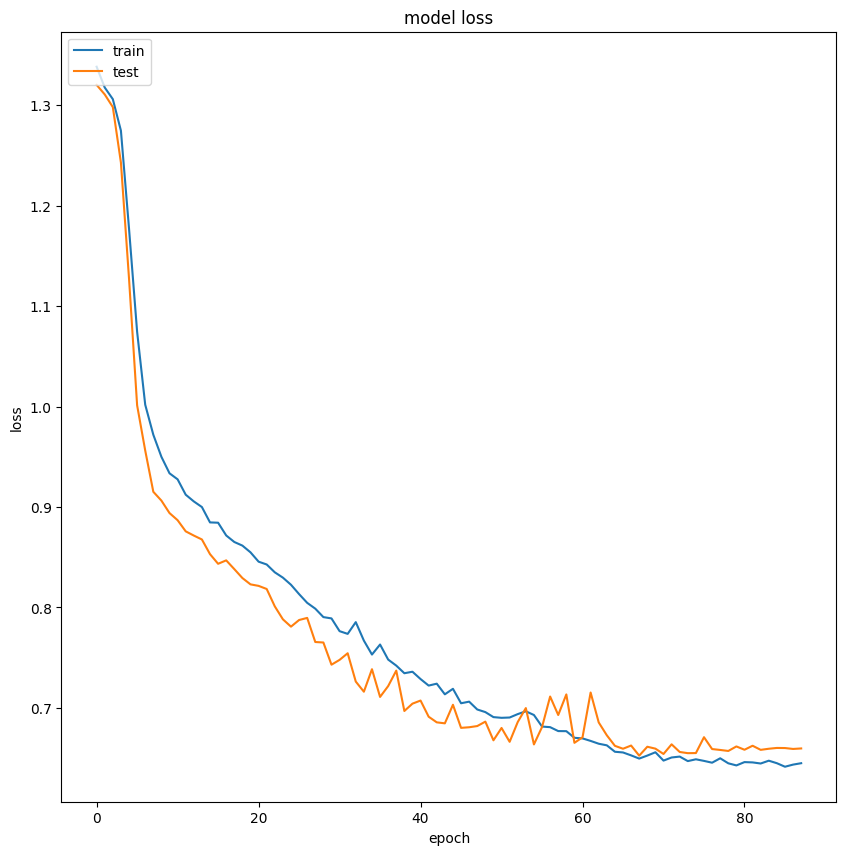

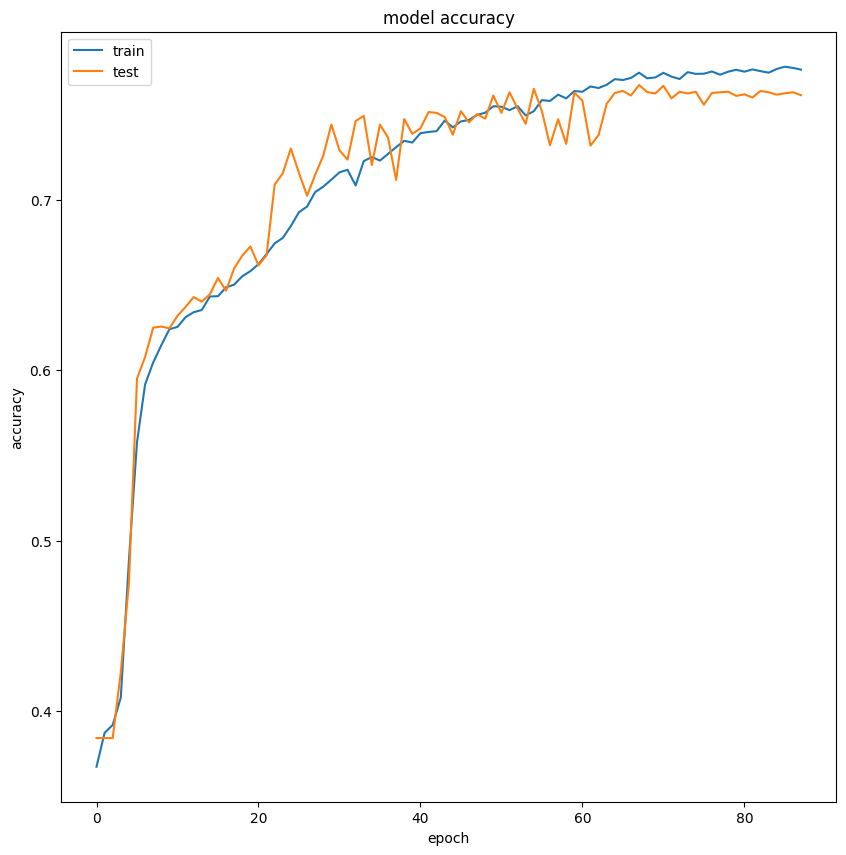

In [29]:
plot_model_history('transformer_history.txt')

Confusion matrix of transformer predictions

233/233 [==============================] - 2s 7ms/step


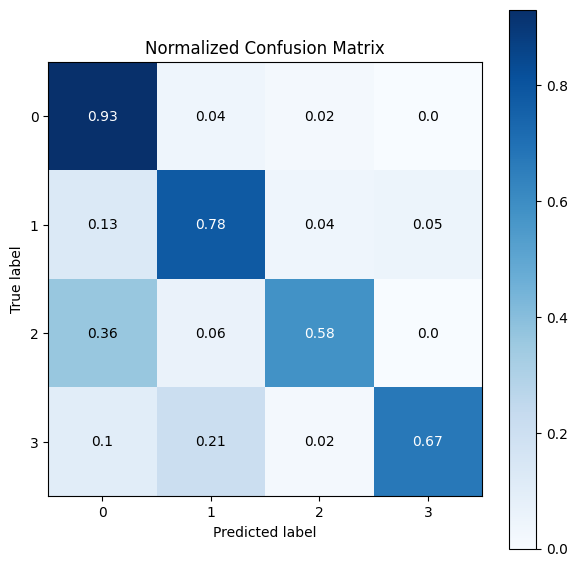

In [34]:
yhat_valid = transformer_model.predict(x_test_transformer)

predicted_classes = np.argmax(yhat_valid, axis=1)

true_classes = y_test_transformer
confuse_fig = scikitplot.metrics.plot_confusion_matrix(
    true_classes,
    predicted_classes,
    normalize='true',
    figsize=(7, 7))
plt.savefig('confusion_matrix.png')

## Generate Tableau File
The code prepares data and uses two machine learning models, an LSTM model and a transformer model, using the prepared data. The trained models are used to make predictions on a test set of data. The last location data in each test sequence is replaced with the LSTM model's location prediction. The predictions from the transformer model are converted from integer class values to corresponding transportation modes using a label dictionary. A random sequence of data from the test set is selected, and its columns are transformed to degrees of latitude and longitude. The transformed data is saved to a CSV file named "tableau_data.csv".
Generate Tableau CSV, ready for import into Tableau. Dashboard available [here](https://public.tableau.com/views/AAI530FinalProject-GPSData/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

In [31]:
generate_tableau_csv()

233/233 [==============================] - 2s 7ms/step
